In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tracker
import stats
import visualizer
import utils

import importlib

import os

In [9]:
# Get Data
data_folder = "./VISEM_Simple_Dataset/"

filenames = os.listdir(data_folder)

if ".DS_Store" in filenames:
    filenames.remove(".DS_Store")

#print(filenames)

# Separate videos from csv files
csvfiles = []
videofiles = []
for filename in filenames:
    if filename.endswith(".csv"):
        csvfiles.append(filename)
    elif filename.endswith(".mp4"):
        videofiles.append(filename)
    else:
        print("Unknown file type: ", filename)

csvfiles.sort()
videofiles.sort()

print(videofiles)
print(csvfiles)


['11.mp4', '12.mp4', '13.mp4', '14.mp4', '15.mp4', '19.mp4', '21.mp4', '22.mp4', '24.mp4', '29.mp4', '30.mp4', '35.mp4', '36.mp4', '38.mp4', '47.mp4', '52.mp4', '54.mp4', '60.mp4', '82.mp4']
['11_labels.csv', '12_labels.csv', '13_labels.csv', '14_labels.csv', '15_labels.csv', '19_labels.csv', '21_labels.csv', '22_labels.csv', '24_labels.csv', '29_labels.csv', '30_labels.csv', '35_labels.csv', '36_labels.csv', '38_labels.csv', '47_labels.csv', '52_labels.csv', '54_labels.csv', '60_labels.csv', '82_labels.csv']


In [16]:
# Visualize example
example_vid = data_folder + videofiles[0]
example_csv = data_folder + csvfiles[0]

df = utils.loadDataFrame(example_csv)

visualizer.runVisualization(example_vid, df, visualization="flow")

(57, 3)


KeyboardInterrupt: 

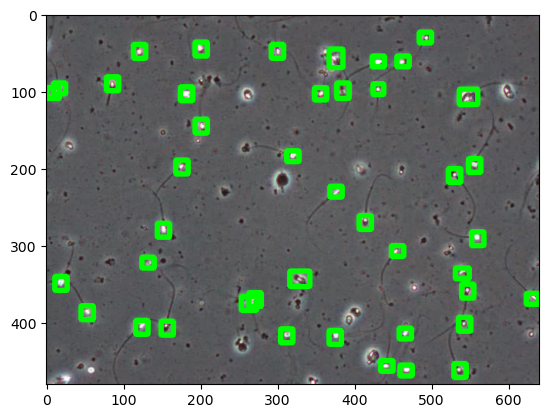

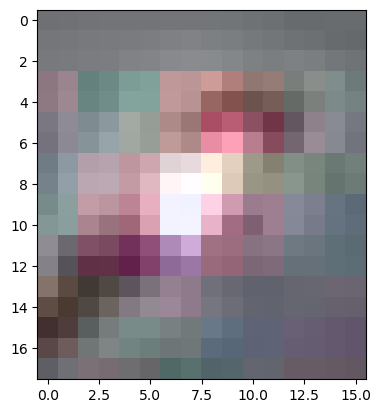

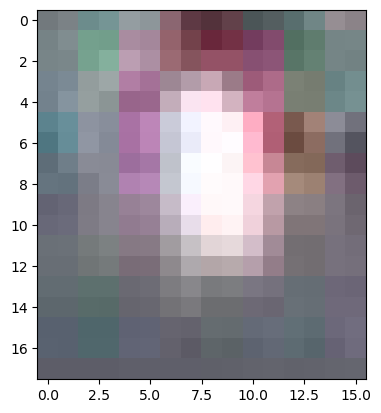

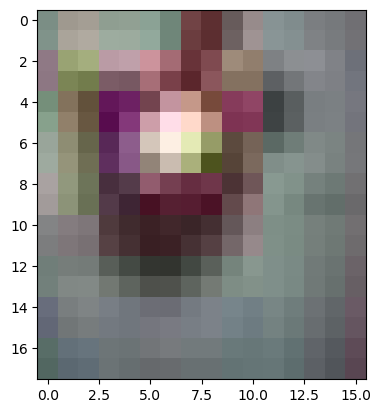

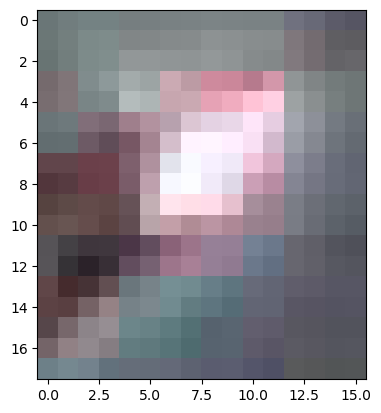

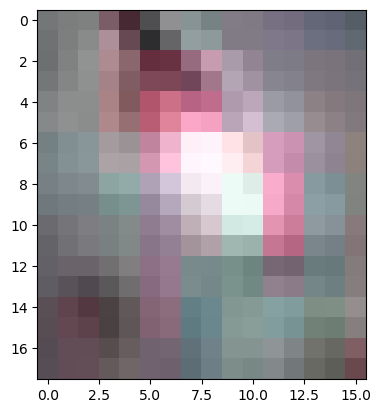

In [56]:
# Example bounding boxes
cap = cv2.VideoCapture(example_vid)

# Get the first frame
ret, frame = cap.read()

original = frame.copy()

res_h, res_w, _ = frame.shape

# Grab the bounding boxes in the first frame
sperm = df[df["frame"] == 0]

for i in range(len(sperm)):
    x = int(sperm.iloc[i]["x"])
    y = int(sperm.iloc[i]["y"])
    w = int(sperm.iloc[i]["bbox_w"])
    h = int(sperm.iloc[i]["bbox_h"])
    cv2.rectangle(frame, (x-w, y-h), (x + w, y + h), (0, 255, 0), 5)
plt.imshow(frame)
plt.show()

# Visualize bounding box regions
for i in range(5):
    x = int(sperm.iloc[i]["x"])
    y = int(sperm.iloc[i]["y"])
    w = int(sperm.iloc[i]["bbox_w"])
    h = int(sperm.iloc[i]["bbox_h"])
    im = original[y-h:y+h, x-w:x+w]
    plt.imshow(im)
    plt.show()  


(18, 16, 3)


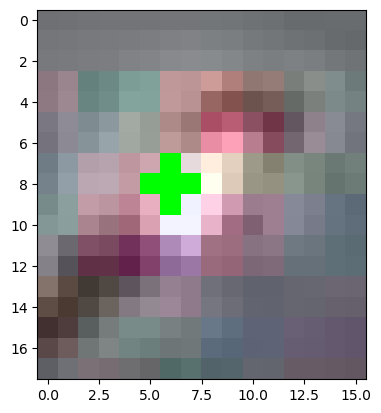

(18, 16, 3)


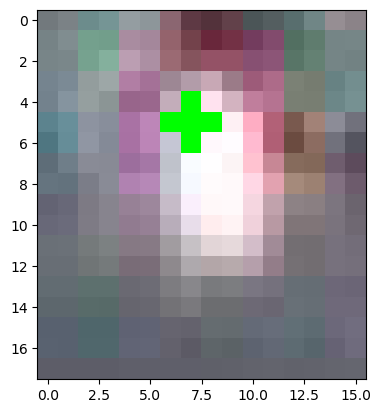

(18, 16, 3)


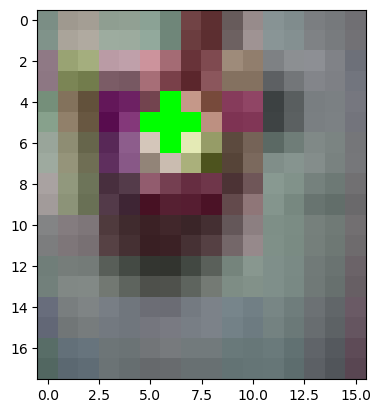

(18, 16, 3)


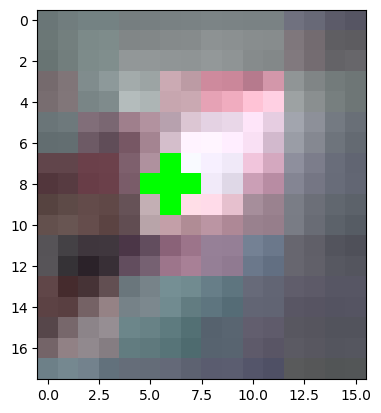

(18, 16, 3)


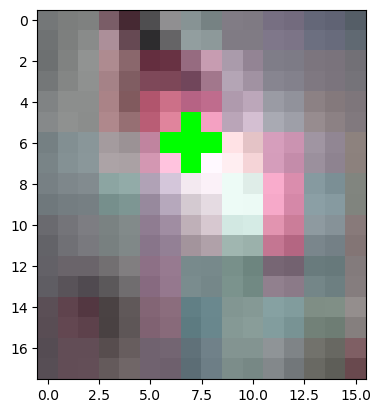

In [57]:
import trackpy as tp
import pandas as pd
import cv2

# Determine true centers using trackpy

def detectTrueCenter(cropped_im):
    predictions = tp.locate(cropped_im, diameter=5, minmass=50, separation=5)

    # Take the row with the highest mass
    predictions = predictions.loc[predictions['mass'] == predictions['mass'].max()]

    return predictions

def detectTrueCenter2(cropped_im):
    f = pd.DataFrame(columns=['y', 'x', 'frame'])

    plt.imshow(cropped_im,cmap='gray')
    plt.show()

    # Find centroids by focusing on heads
    bw = tracker.threshold(cropped_im, method='otsu')
    plt.imshow(bw,cmap='gray')
    plt.show()
    _, _, _, centroids = cv2.connectedComponentsWithStats(bw, 4, cv2.CV_32S) 

    # Filter out the background (always index 0)
    centroids = centroids[1:]

    # Add centroids to dataframe
    for centroid in centroids:
        f.loc[len(f.index)] = [centroid[1], centroid[0], i]

    return f

# Draw the opencv detection
for i in range(5):
    x = int(sperm.iloc[i]["x"])
    y = int(sperm.iloc[i]["y"])
    w = int(sperm.iloc[i]["bbox_w"])
    h = int(sperm.iloc[i]["bbox_h"])
    im = original[y-h:y+h, x-w:x+w]
    im_g = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    print(im.shape)
    info = detectTrueCenter(im_g)
    for j in range(len(info)):
        x = int(info.iloc[j]["x"])
        y = int(info.iloc[j]["y"])
        cv2.circle(im, (x, y), 1, (0, 255, 0), -1)
    plt.imshow(im)
    plt.show()



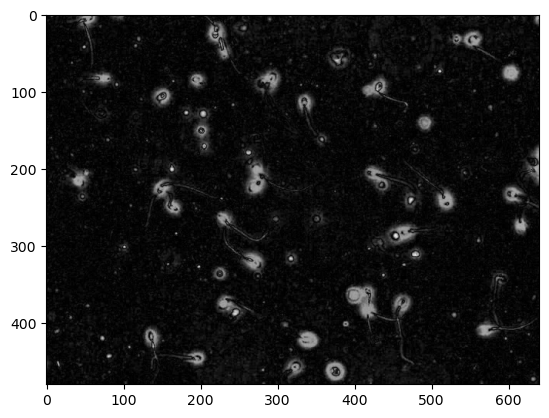

In [18]:
# Visualize the input
cap = cv2.VideoCapture(videofile)

# Get the first frame
ret, frame = cap.read()

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

frame = utils.medianFilter(frame)

plt.imshow(frame, cmap='gray')

### Feed through the tracking pipeline

In [19]:
importlib.reload(tracker)
importlib.reload(utils)

frames = utils.loadVideo(videofile,as_gray=True)
frames = utils.medianFilter(frames)
f = tracker.determineCentroids(frames)
t = tracker.trackCentroids(f)

print(t.head())

Frame 1439: 356 trajectories present.
            y           x        mass      size       ecc     signal  \
0  312.082601  454.961336  115.590371  1.659504  0.203675  11.579352   
1  315.735484  275.959677  125.950844  1.820581  0.470139  10.360473   
2  316.898851  317.606892  636.661201  1.720127  0.136317  49.974044   
3  323.457212  268.917308  422.544766  1.728300  0.323792  37.988400   
4  323.907032  157.980930  170.439932  1.262836  0.123303  26.612194   

   raw_mass        ep  frame  sperm  
0     504.0  0.120271      0      1  
1     660.0  0.084107      0      2  
2    2461.0  0.018810      0      3  
3    1828.0  0.025869      0      4  
4     503.0  0.120604      0      5  


In [21]:
importlib.reload(tracker)

compute_segments = False
if compute_segments:
    final = tracker.segmentCells(frames, t)
else:
    final = t

print(final.head())

            y           x        mass      size       ecc     signal  \
0  312.082601  454.961336  115.590371  1.659504  0.203675  11.579352   
1  315.735484  275.959677  125.950844  1.820581  0.470139  10.360473   
2  316.898851  317.606892  636.661201  1.720127  0.136317  49.974044   
3  323.457212  268.917308  422.544766  1.728300  0.323792  37.988400   
4  323.907032  157.980930  170.439932  1.262836  0.123303  26.612194   

   raw_mass        ep  frame  sperm  
0     504.0  0.120271      0      1  
1     660.0  0.084107      0      2  
2    2461.0  0.018810      0      3  
3    1828.0  0.025869      0      4  
4     503.0  0.120604      0      5  


In [24]:
#utils.saveDataFrame(final, videofile.split('.')[0] + '.csv')
print(videofile.split('.')[0] + '.csv')

.csv


### Feed through the statistics pipeline

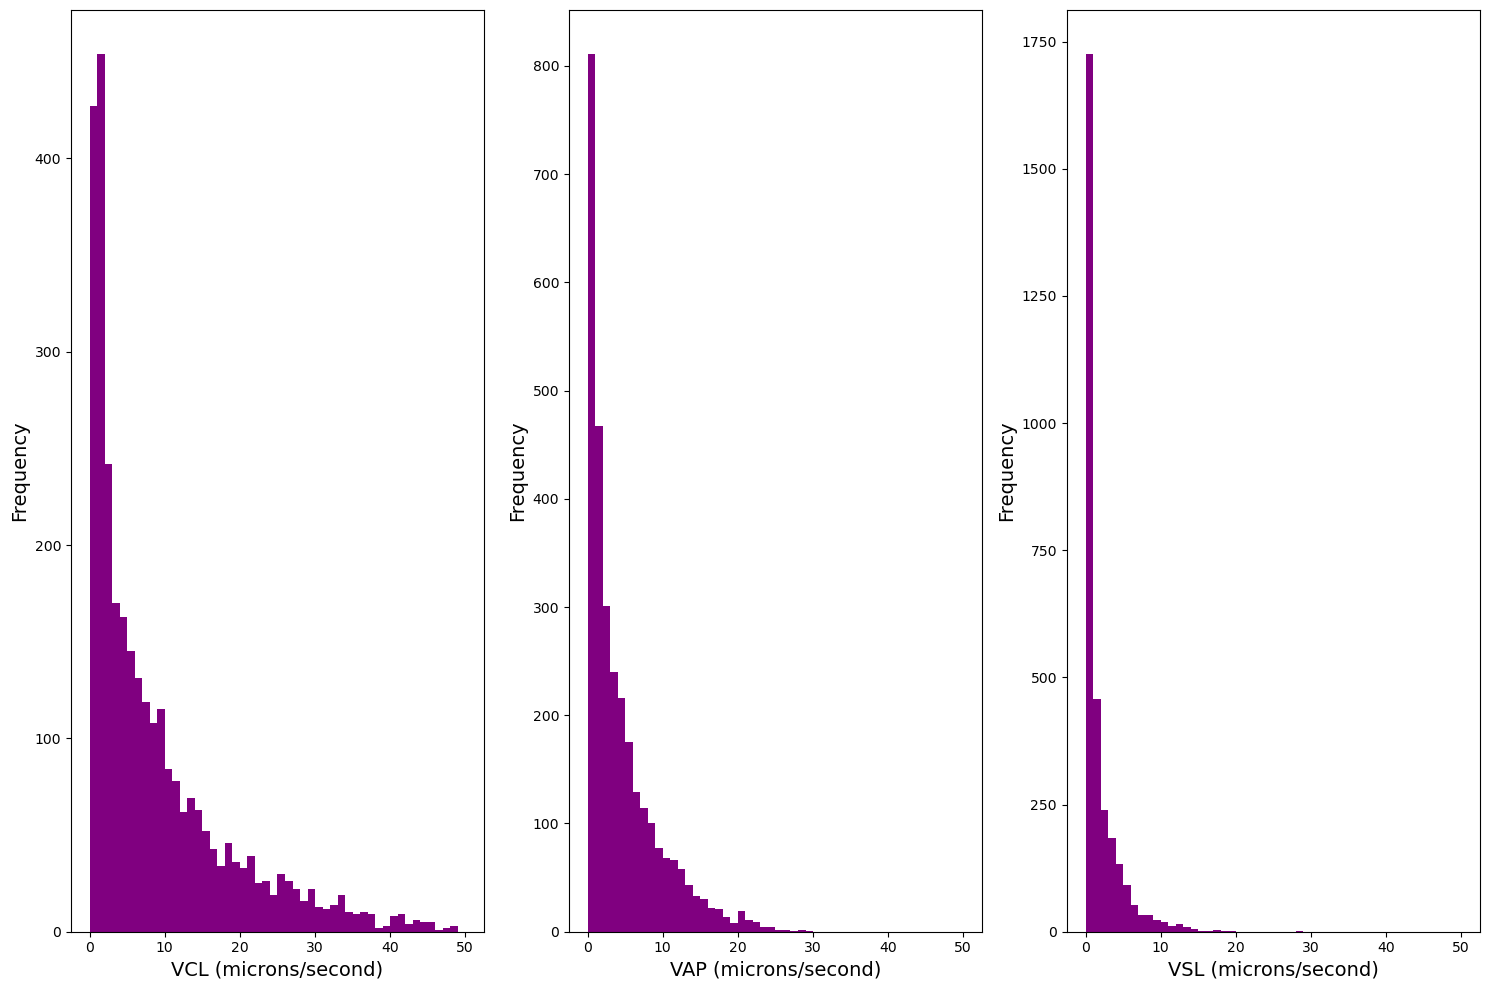

            y           x        mass      size       ecc     signal  \
0  312.082601  454.961336  115.590371  1.659504  0.203675  11.579352   
1  313.059711  452.783155  299.266273  1.831356  0.134936  20.126644   
2  313.033909  452.843890  296.122207  1.863376  0.175164  18.945759   
3  313.049472  452.866095  294.651668  1.841331  0.181884  18.853042   
4  313.157791  452.812623  293.711503  1.870389  0.173027  17.765587   

   raw_mass        ep  frame  sperm       VAP      VCL       VSL   ALH_mean  \
0     504.0  0.120271    0.0    1.0  1.416909  3.07943  0.412353  34.680045   
1    1266.0  0.033518    1.0    1.0  1.416909  3.07943  0.412353  34.680045   
2    1297.0  0.031704    2.0    1.0  1.416909  3.07943  0.412353  34.680045   
3    1292.0  0.033515    3.0    1.0  1.416909  3.07943  0.412353  34.680045   
4    1274.0  0.036565    4.0    1.0  1.416909  3.07943  0.412353  34.680045   

     ALH_max       BCF  
0  68.358429  0.127841  
1  68.358429  0.127841  
2  68.358429  0.1

In [23]:
importlib.reload(stats)

final = stats.computeAllStats(final)
stats.plotAllStats(final)

print(final.head())

In [ ]:
#utils.saveDataFrame(final, videofile.split('.')[0] + '.csv')

### Use Visualizations

In [28]:
importlib.reload(visualizer)

visualizer.runVisualization(videofile, final, visualization="flow")

(7233, 3)
Video Finished.


## Extract bounding boxes from labels data

                        ftid  type         x         y    bbox_w    bbox_h
0  ckz3w7jvs001b3867v3h4p4s2     0  0.121094  0.175000  0.042188  0.054167
1  cl4dmy6pl0007356fb5434fln     0  0.084375  0.026042  0.050000  0.047917
2  cl4dmz269000a356fbourf6gh     0  0.348438  0.048958  0.046875  0.060417
3  cl4dmzfpu000e356febbq1mdv     0  0.358594  0.110417  0.042188  0.050000
4  cl4dmznh7000h356fz64w6qfx     0  0.454688  0.176042  0.043750  0.064583


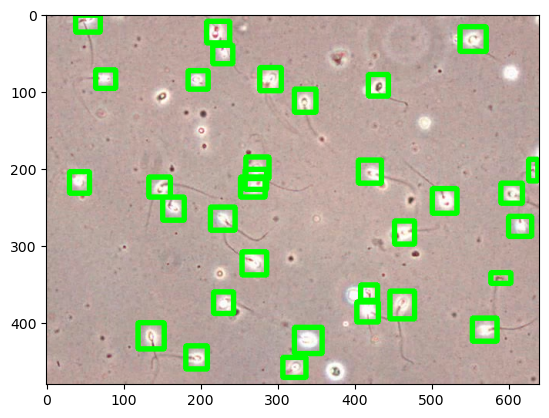

In [60]:
import pandas as pd

# Get Data
data_folder = "../VISEM-Tracking/VISEM_Tracking_Train_v4/Train/"

folder_nums = os.listdir(data_folder)

if ".DS_Store" in folder_nums:
    folder_nums.remove(".DS_Store")

folder_num = folder_nums[0]
videofile = data_folder + folder_num + "/" + folder_num + ".mp4"
images_folder = data_folder + folder_num + "/images/"
labels_folder = data_folder + folder_num + "/labels_ftid/"

frame_num = 0
image_fn = folder_num + "_frame_" + str(frame_num) + ".jpg"

image = cv2.imread(images_folder + image_fn)
#plt.imshow(image)
#plt.show()

data_txt_fn = folder_num + "_frame_" + str(frame_num) + "_with_ftid.txt"

# Convert space separated txt to pandas
df = pd.read_csv(labels_folder + data_txt_fn, sep=" ", header=None)
df.columns = ["ftid", "type", "x", "y", "bbox_w", "bbox_h"]
print(df.head())

# Plot bounding boxes
res_h, res_w = image.shape[:2]

for i in range(len(df)):
    x = int(df.iloc[i]["x"] * res_w)
    y = int(df.iloc[i]["y"] * res_h)
    w = int(df.iloc[i]["bbox_w"] * res_w)//2
    h = int(df.iloc[i]["bbox_h"] * res_h)//2
    cv2.rectangle(image, (x-w, y-h), (x + w, y + h), (0, 255, 0), 5)
plt.imshow(image)
plt.show()


# Get the first frame
#with frame_num = 0:
#    image = cv2.imread(images_folder + str(frame_num) + ".png")

 

## Convert dataset to CSV

In [75]:
import pandas as pd
from tqdm import tqdm, trange

# Get Data
data_folder = "../VISEM-Tracking/VISEM_Tracking_Train_v4/Train/"

folder_nums = os.listdir(data_folder)

if ".DS_Store" in folder_nums:
    folder_nums.remove(".DS_Store")

folder_nums = sorted(folder_nums)

print(folder_nums)

#for folder_num in ["47","82"]:
for folder_num in folder_nums:
    videofile = data_folder + folder_num + "/" + folder_num + ".mp4"
    images_folder = data_folder + folder_num + "/images/"
    labels_folder = data_folder + folder_num + "/labels_ftid/"

    # Load one image to get the size
    images = os.listdir(images_folder)
    image_fn = images[0]
    image = cv2.imread(images_folder + image_fn)
    res_h, res_w = image.shape[:2]

    num_frames = len(os.listdir(labels_folder))

    final = pd.DataFrame()
    #final.columns = ["ftid", "type", "x", "y", "bbox_w", "bbox_h"]

    # Loop through all frames
    for frame_num in trange(0,num_frames):
        data_txt_fn = folder_num + "_frame_" + str(frame_num) + "_with_ftid.txt"

        # Convert space separated txt to pandas
        df = pd.read_csv(labels_folder + data_txt_fn, sep=" ", header=None)
        df.columns = ["sperm", "type", "x", "y", "bbox_w", "bbox_h"]

        # Add frame number
        df["frame"] = int(frame_num)

        final = pd.concat([final, df], ignore_index=True)

    # Convert x, y, bbox_w, bbox_h to int
    final["x"] = (final["x"] * res_w).astype(int)
    final["y"] = (final["y"] * res_h).astype(int)
    final["bbox_w"] = (final["bbox_w"] * res_w/2).astype(int)
    final["bbox_h"] = (final["bbox_h"] * res_h/2).astype(int)

    # Convert ftid to int via a lookup table
    ftid_lookup = final["sperm"].unique()
    ftid_lookup = {ftid: i for i, ftid in enumerate(ftid_lookup)}
    final["sperm"] = final["sperm"].map(ftid_lookup)
    final["type"] = final["type"].astype(int)
    final["sperm"] = final["sperm"].astype(int)

    # Save the final dataframe
    final.to_csv(data_folder + folder_num + "/" + folder_num + ".csv", index=False)

['11', '12', '13', '14', '15', '19', '21', '22', '23', '24', '29', '30', '35', '36', '38', '47', '52', '54', '60', '82']


100%|██████████| 1500/1500 [01:07<00:00, 22.27it/s]


## Example plotting

In [5]:
importlib.reload(visualizer)
import pandas as pd

videofile = "VISEM_Simple_Dataset/13.mp4"
final = pd.read_csv("VISEM_Simple_Dataset/13_labels.csv")

visualizer.runVisualization(videofile, final, visualization="flow")

(78, 3)
Video Finished.
